c:\Users\SCP\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


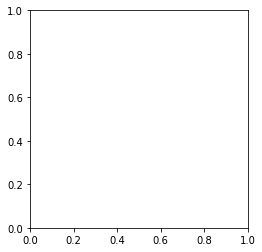

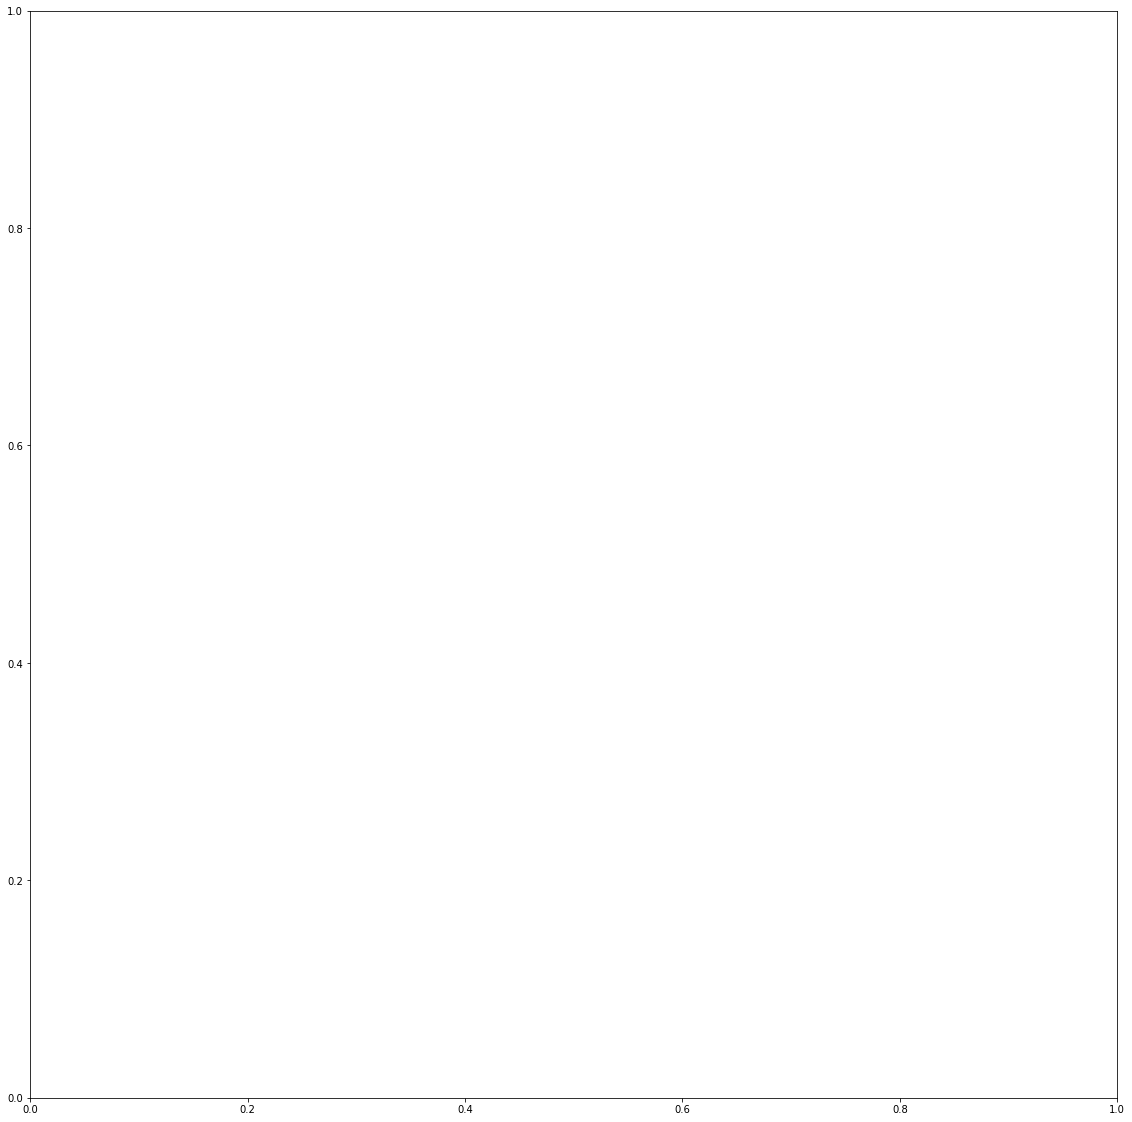

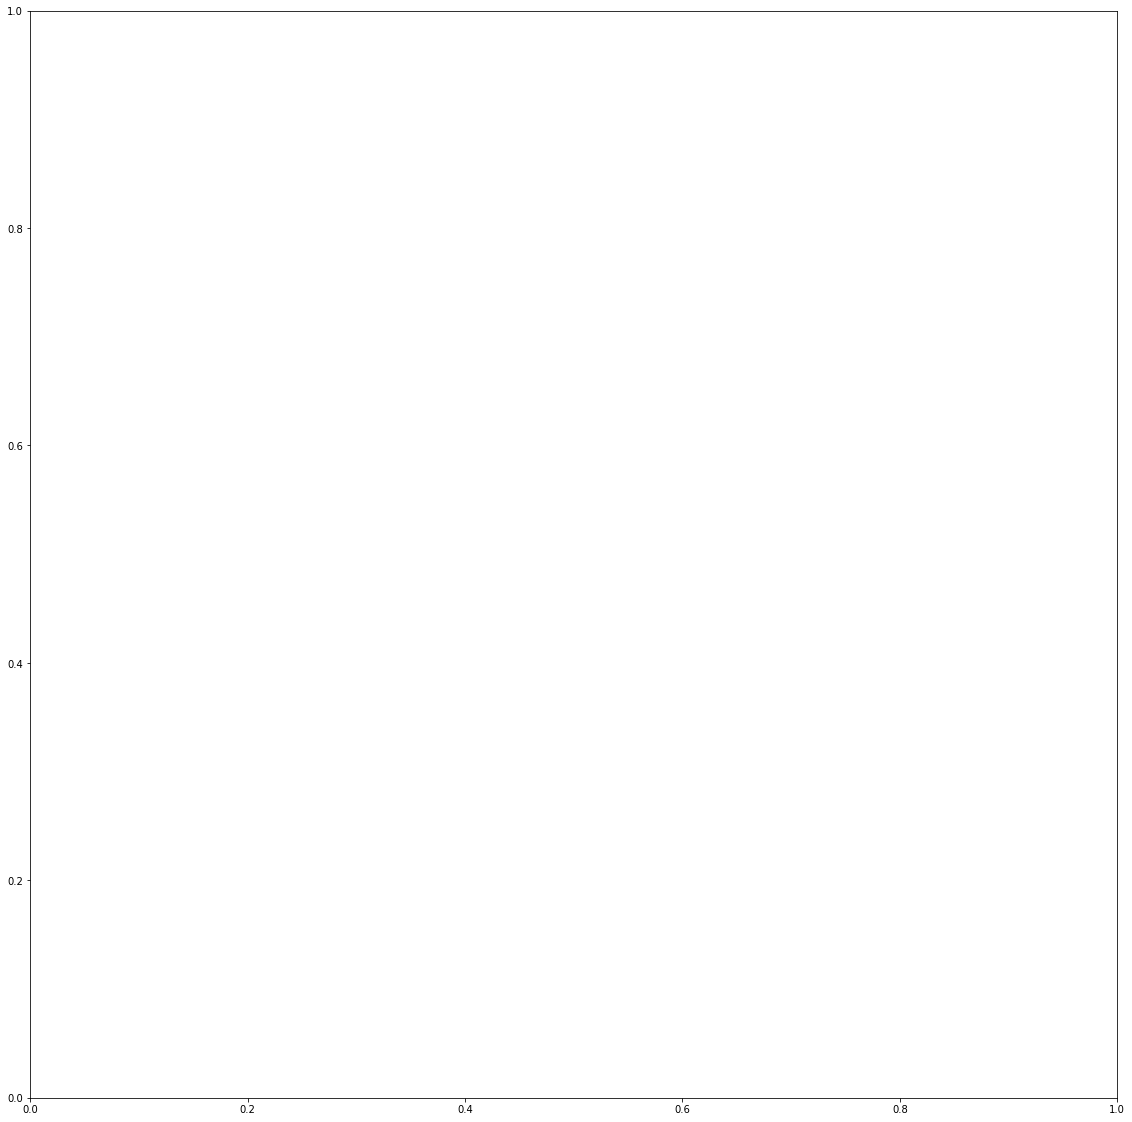

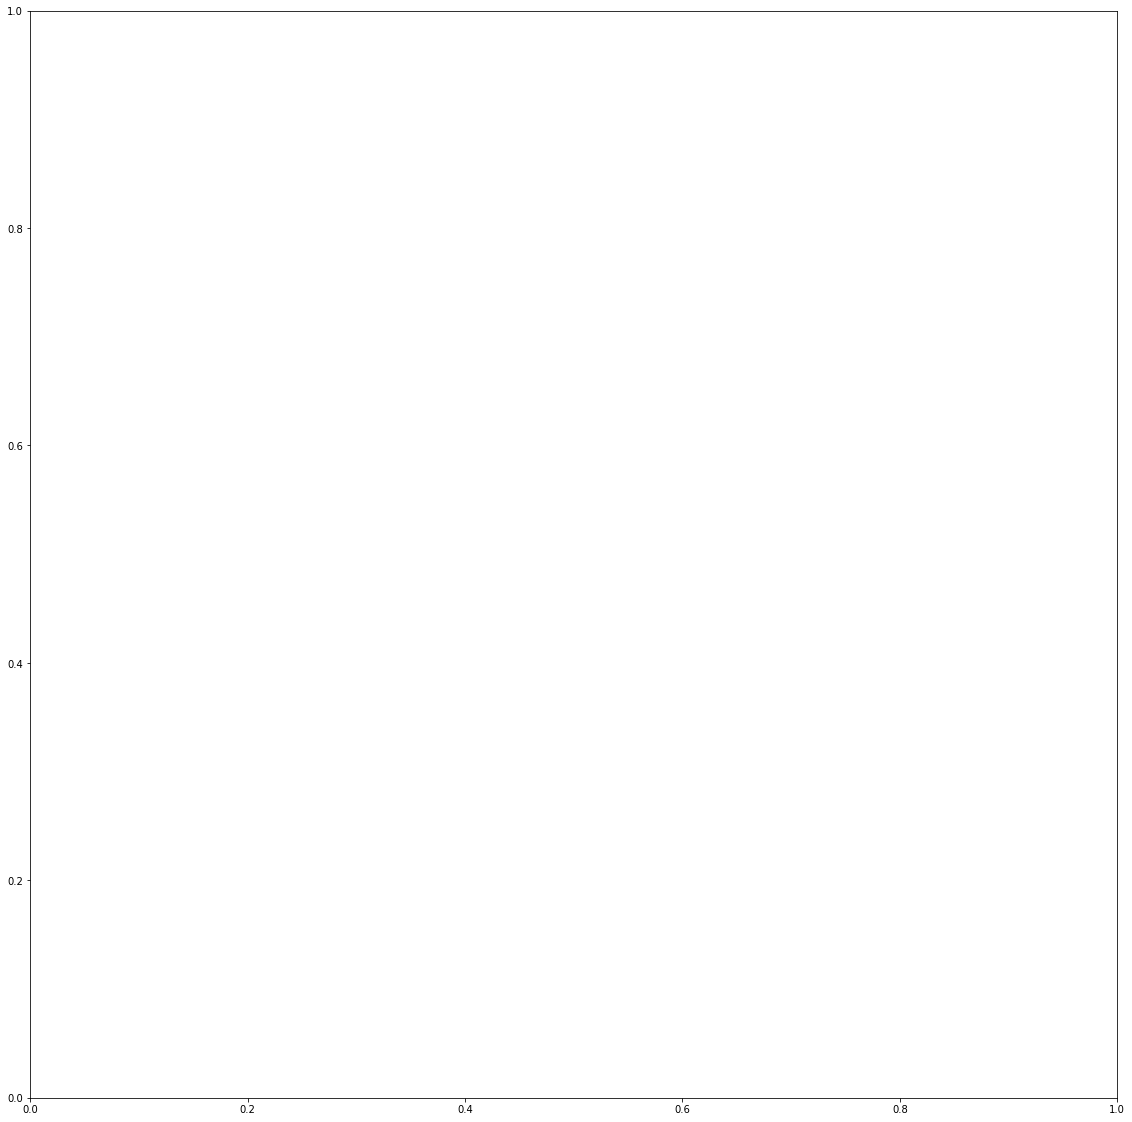

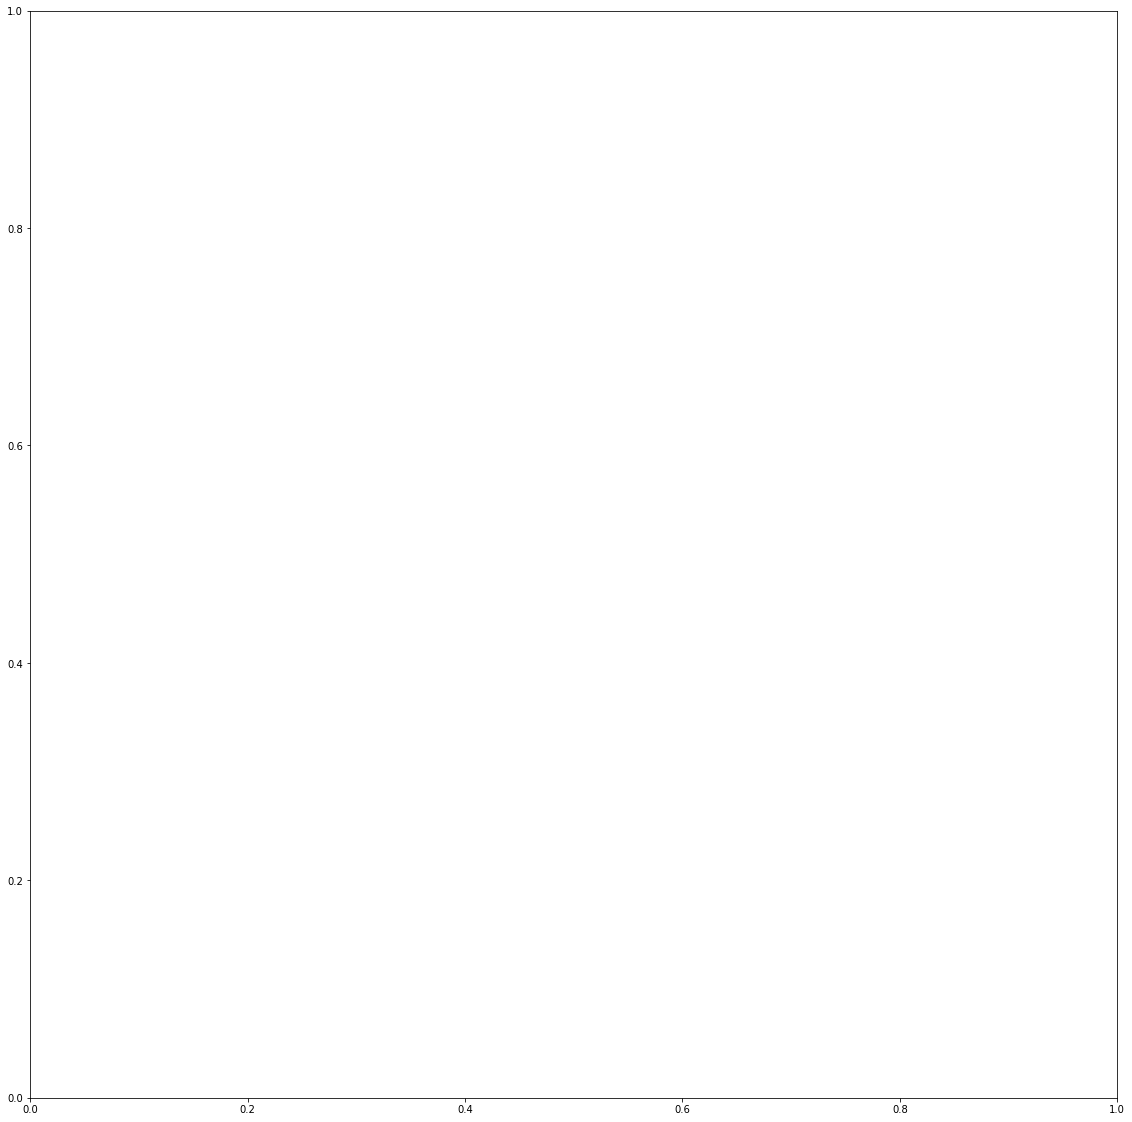

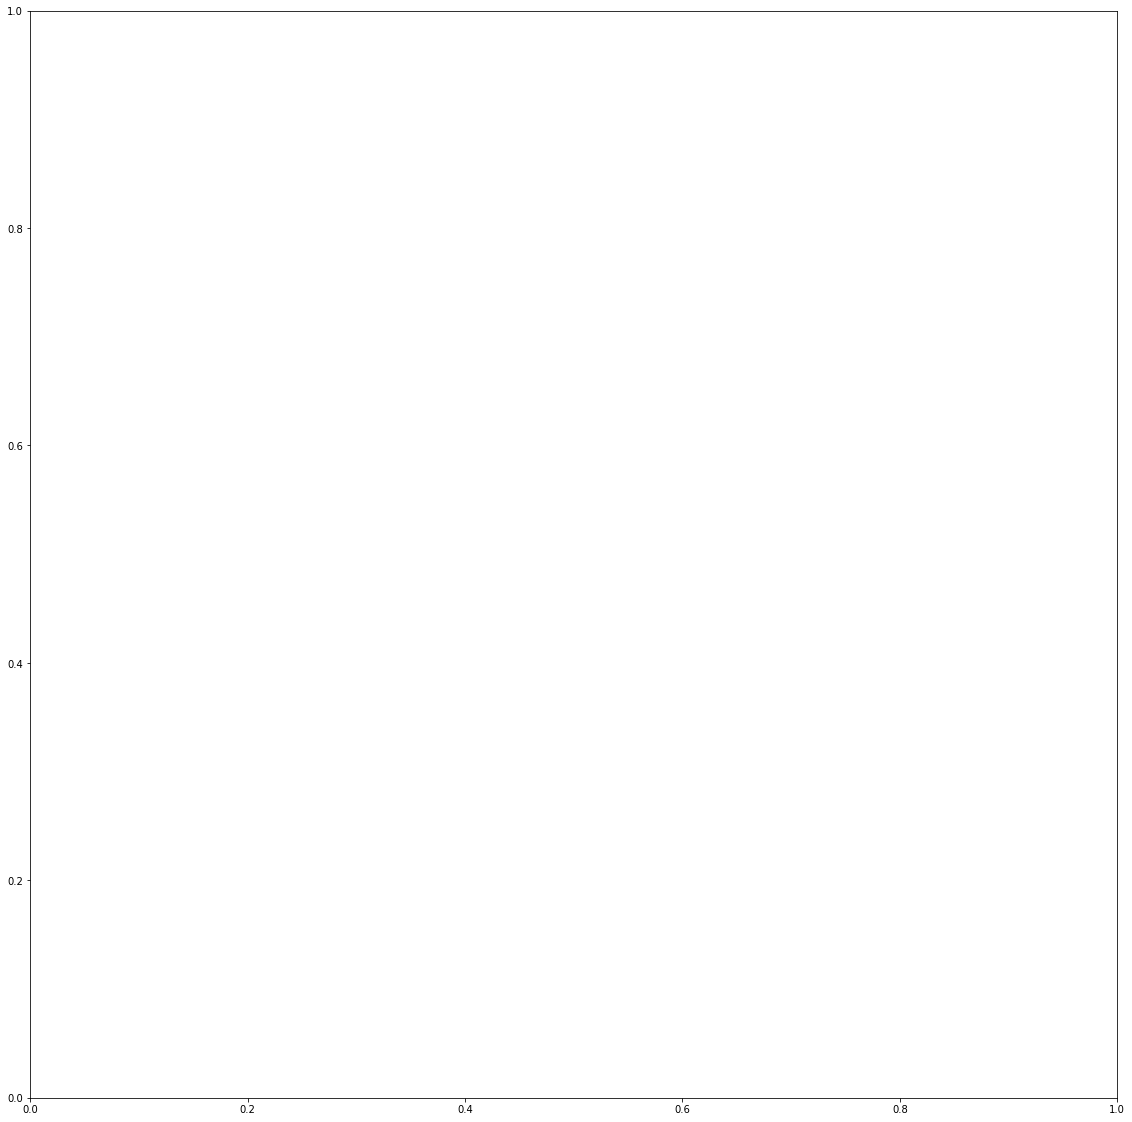

In [1]:
import torch
from numpy import array
from numpy.linalg import norm
import math

import random
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import os
plt.axes().set_aspect('equal')

x = []
y = []
z = []


# Random float number between range 10.5 to 75.5
for i in range(5000):
  x.append(random.uniform(-1, 1))
  y.append(random.uniform(-1, 1))
  z.append(random.uniform(-1, 1))

for i in range(len(x)):
  norm_ = math.sqrt(x[i]**2 + y[i]**2 + z[i]**2)
  #print(norm)
  x[i] /= norm_
  y[i] /= norm_
  z[i] /= norm_
c1 = [0.5, -1, 0]
c2 = [0.2, -1, 0.5]
c3 = [0., -1, 0]

c1 /= norm(array(c1), 2)
c2 /= norm(array(c2), 2)
c3 /= norm(array(c3), 2)
samples = []
#centroid = [x[0], y[0], z[0]]
for i in range(len(x)):
  point = [x[i], y[i], z[i]]
  product = np.dot(c1, point)
  lower_bound = 0.97
  upper_bound = 0.99
  #if(product > 0.8 and product < 0.9):
  if(product > lower_bound and product < upper_bound):
      samples.append(i)

  product = np.dot(c2, point)
  #if(product > 0.8 and product < 0.9):
  if(product > lower_bound and product < upper_bound):
      samples.append(i)

  product = np.dot(c3, point)
  #if(product > 0.8 and product < 0.9):
  if(product > lower_bound and product < upper_bound):
      samples.append(i)


ws = []
ring_x = [x[i] for i in samples]
ring_y = [y[i] for i in samples]
ring_z = [z[i] for i in samples]

for ind in range(len(ring_x)):
  w = torch.tensor([ring_x[ind], ring_y[ind], ring_z[ind]])

  w.requires_grad_()
  ws.append(w)


c1 = torch.tensor(c1)
c2 = torch.tensor(c2)
c3 = torch.tensor(c3)
c1 = c1.float()
c2 = c2.float()
c3 = c3.float()

pdist = torch.nn.PairwiseDistance(p=2)

epochs = 10


for epoch in range(epochs):
  #print('\n', epoch)
  # compute the distance
  loss = 0


  for point in ws:

    # Simple L2 distance-based loss - equal penalization 
    #z += -1*((pdist(point, c1)) + (pdist(point, c2)) + (pdist(point, c3)))


    # y = 1/x loss function - 'highly penalizes a point for being close to centroid
    #z += 1/((pdist(point, c1)) + (pdist(point, c2)) + (pdist(point, c3)))


    #z += math.log((pdist(point, c1)) + (pdist(point, c2)) + (pdist(point, c3)))
    #z += -1*((pdist(point, c1)**2) + (pdist(point, c2)**2) + (pdist(point, c3)**2))
    #z += ((1/pdist(point, c1)) + (1/pdist(point, c2)) + (1/pdist(point, c3)))
    loss += ((1/pdist(point, c1)) + (1/pdist(point, c2)) + (1/pdist(point, c3)))

    cos_1 = torch.dot(c1, point)
    cos_2 = torch.dot(c2, point)
    cos_3 = torch.dot(c3, point)
    #z += ((1/pdist(point, c1)) + (1/pdist(point, c2)) + (1/pdist(point, c3)))
    #z += -1*(torch.log(1 - cos_1) + torch.log(1 - cos_2))

    # our final loss that 'highly' penalizes a point for being close to centroid (voiled graph in ppt)
    #loss += -1*(torch.log(1 - cos_1)) + torch.log(torch.tensor(2)) + -1*(torch.log(1 - cos_2)) + torch.log(torch.tensor(2)) + -1*(torch.log(1 - cos_3)) + torch.log(torch.tensor(2))
    
    # SupCon
    # From equation (2) in SupCon paper
    #loss += torch.log(torch.exp(cos_1) + torch.exp(cos_2) + torch.exp(cos_3))
  
  #print(loss)
  
  loss.backward()
  
  with torch.no_grad():
    for point in ws:
      #print(point.grad) 
      point -= 0.005*point.grad
      point /= norm(array(point), 2)
      point.grad = None

  if(epoch < 20):
    visualization_frequency = 2
  elif (epoch < 100):
    visualization_frequency = 10
  else:
    visualization_frequency = 100
    

  if(epoch % visualization_frequency == 0):

    updated_x = [float(i[0]) for i in ws]
    updated_y = [float(i[1]) for i in ws]
    updated_z = [float(i[2]) for i in ws]

    fig = plt.figure(figsize=(20,20))
    
    # syntax for 3-D projection
    ax = plt.axes(projection ='3d')

    ax.scatter(x, y, z, c='lightgrey', s = 5)
    ax.scatter(c1[0], c1[1], c1[2], c='blue', s = 200)
    ax.scatter(c2[0], c2[1], c2[2], c='red', s = 200)
    ax.scatter(c3[0], c3[1], c3[2], c='green', s = 200)
    ax.scatter(ring_x, ring_y, ring_z, c='darkred', s = 40)
    ax.scatter(updated_x, updated_y, updated_z, s = 40)

    #plt.axes().set_aspect('equal')
    #plt.show()



    if not os.path.exists('images'):
      os.makedirs('images')
    fig.savefig('./images/' + str(epoch) + '.png')